In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import json
import pandas as pd
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
cm = plt.get_cmap('viridis_r')
plt.style.use('seaborn-paper')

In [15]:
ALL_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHODS = [ 'cbas', 'rwr', 'fbvae', 'dbas', 'cem-pi', 'killoran', 'bombarelli', 'bombarelli-unconstrained']
METHOD_COLORS = {METHODS[i]: ALL_COLORS[i] for i in range(len(METHODS))}

In [16]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [17]:
# plt.legend(frameon=False)
# plt.grid(True)
# plt.gca().set_axisbelow(True)
# plt.gca().grid(color='gray', alpha=0.2)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().yaxis.set_ticks_position('left')
# plt.gca().xaxis.set_ticks_position('bottom')
# plt.tight_layout()
# plt.show()

In [18]:
def plot_sorted_samples():
    fig = plt.figure(figsize=(4, 3))
    suffix = '_hetero_1'
    methods = ['cbas', 'rwr']
#     cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     colors = [cs[2], cs[1]]
    for j in range(len(methods)):
        method = methods[j]
        oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix)).flatten()
        gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix)).flatten()
        sorted_idx = np.argsort(oracle_samples)
        sorted_oracle = oracle_samples[sorted_idx]
        sorted_gt = gt_samples[sorted_idx]
        x = range(len(sorted_idx))
        plt.xlabel("Sorted Index")
        plt.ylabel("$y$")
        plt.plot(range(len(sorted_oracle)), sorted_oracle,c=METHOD_COLORS[method], ls='--', lw=1, label="%s Oracle" % method.upper())
        plt.scatter(range(len(sorted_gt)), sorted_gt, s=0.5, c=METHOD_COLORS[method], label="%s GT" % method.upper(), alpha=0.5)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.tight_layout()
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
#     plt.savefig('toy_setup.png', dpi=500)
    plt.show()

In [19]:
# plot_sorted_samples()

In [57]:
def plot_traj(quantile=0.8, sort=True, mean=False, use_first=50, sub=True):
    for i in range(1, 4):
        for j in range(3):
            fig = plt.figure(figsize=(4, 3))
            suffix = '_5k_%i_%i' %(i, j)
            if sub:
                methods = [ 'cbas', 'fbvae', 'rwr']
            else:
                methods = [ 'cbas', 'fbvae', 'rwr', 'dbas', 'cem-pi']
            for k in range(len(methods)):
                method = methods[k]
#                 traj = np.load('results/%s_traj%s.npy' %(method, suffix))
                oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[:use_first]
                gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[:use_first]
                
                if mean:
                    oracle_vals= np.mean(oracle_samples, axis=1)
                    gt_vals = np.mean(gt_samples, axis=1)
                else:
                    per = np.percentile(oracle_samples, quantile*100, axis=-1)
                    per = per.reshape(oracle_samples.shape[0], 1)
                    oracle_idxs = np.where(oracle_samples > per)
                    
                    oracle_vals = np.zeros_like(oracle_samples)
                    oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
                    oracle_vals = np.true_divide(oracle_vals.sum(1),(oracle_vals!=0).sum(1))
                    
                    gt_vals = np.zeros_like(gt_samples)
                    gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
                    gt_vals = np.true_divide(gt_vals.sum(1),(gt_vals!=0).sum(1))
#                     oracle_idxs = np.where()
#                     oracle_vals= np.percentile(oracle_samples, quantile*100, axis=1)
#                     gt_vals = np.percentile(gt_samples, quantile*100, axis=1)
                
                x = range(oracle_samples.shape[0])
                if sort:
                    sorted_idx = np.argsort(oracle_vals)
                else:
                    sorted_idx = range(len(x))
                    
                plt.plot(x, gt_vals[sorted_idx], c=METHOD_COLORS[method], label="%s" % method.upper(), zorder=len(methods)-j)
                plt.plot(x, oracle_vals[sorted_idx], c=METHOD_COLORS[method], ls='--', zorder=len(methods)-j)

            plt.ylabel("$%i^{th}$ percentile of $y$ samples" % int(quantile*100))
            plt.xlabel("Iteration (sorted by oracle values)")
        #     plt.xlabel("$t$")
#             plt.ylim([2.95, 3.4])
            plt.legend(frameon=True, loc='lower left')
            plt.grid(True)
            plt.gca().set_axisbelow(True)
            plt.gca().grid(color='gray', alpha=0.2)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')
        #     plt.savefig('toy_setup.png', dpi=500)
#             [i.set_linewidth(0.1) for i in plt.gca().spines.itervalues()]
            if sub:
                plt_name = "plots/traj_%.1f_%i_%i_sub.png" % (quantile, i, j)
            else:
                plt_name = "plots/traj_%.1f_%i_%i_all.png" % (quantile, i, j)
            print(plt_name)
            plt.tight_layout()
            plt.savefig(plt_name, dpi=500)
            plt.show()

plots/traj_0.8_1_0_all.png


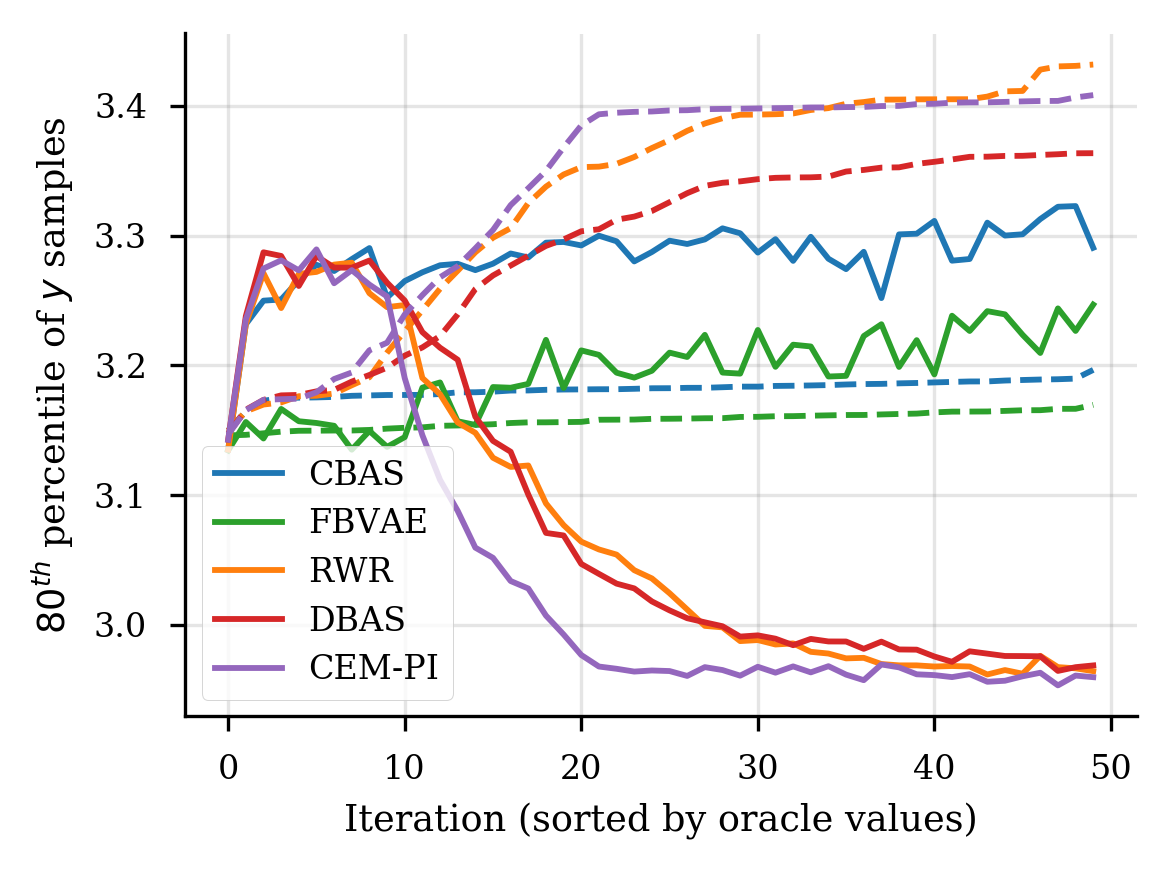

plots/traj_0.8_1_1_all.png


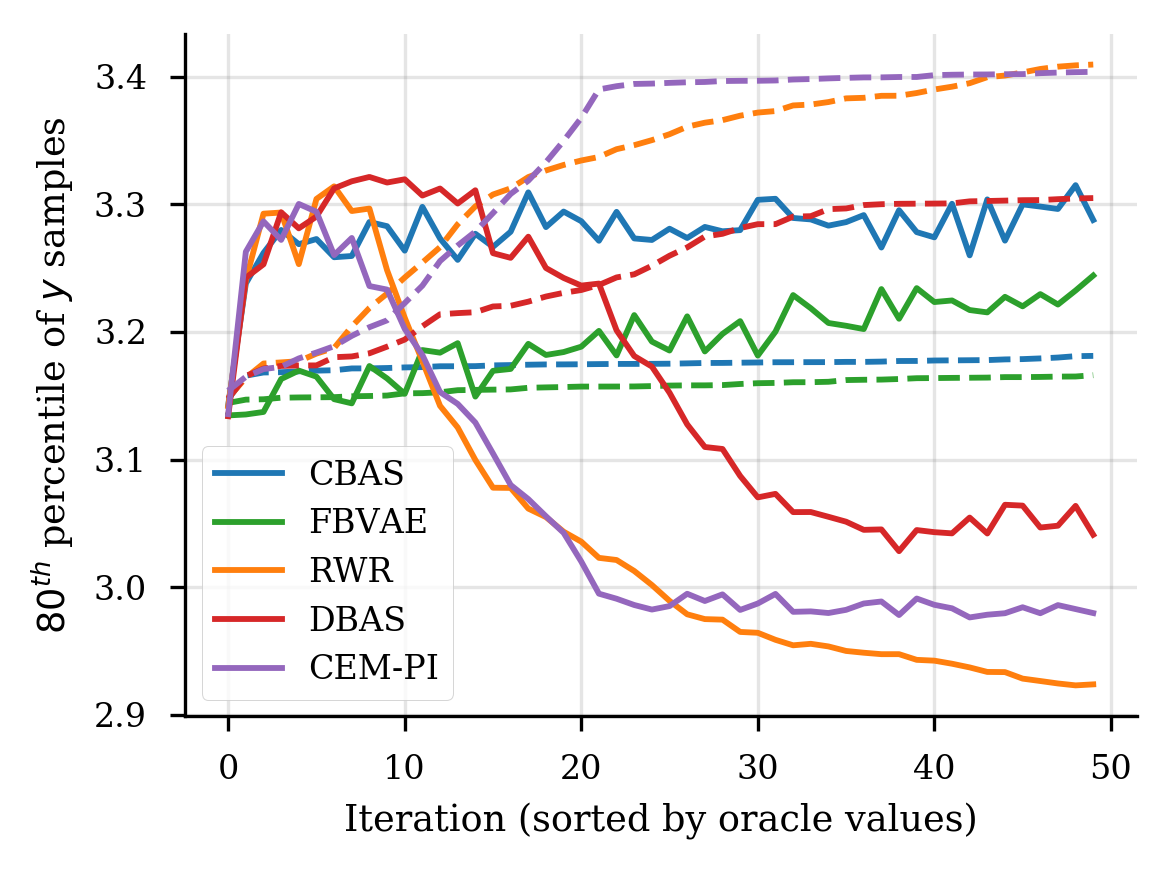

plots/traj_0.8_1_2_all.png


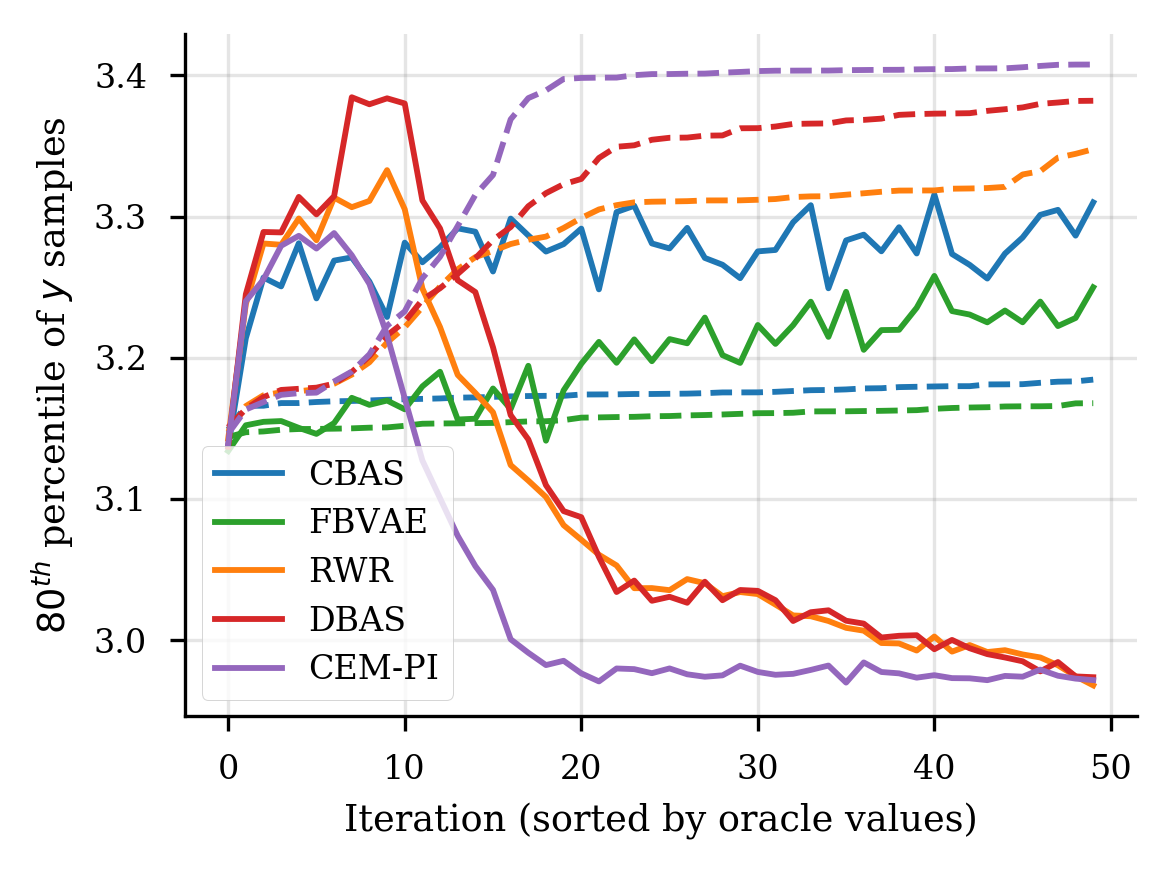

/global/homes/d/dbrookes/myconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/global/homes/d/dbrookes/myconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


plots/traj_0.8_2_0_all.png


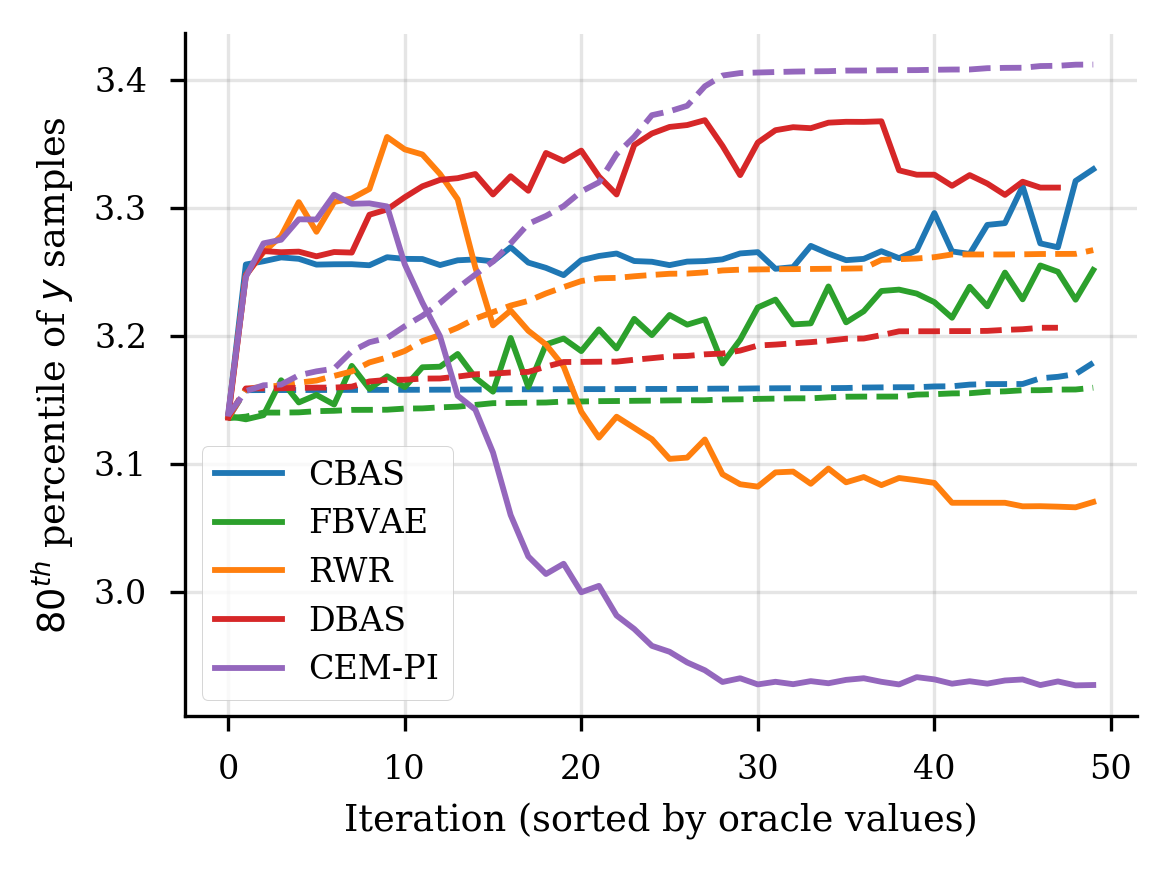

plots/traj_0.8_2_1_all.png


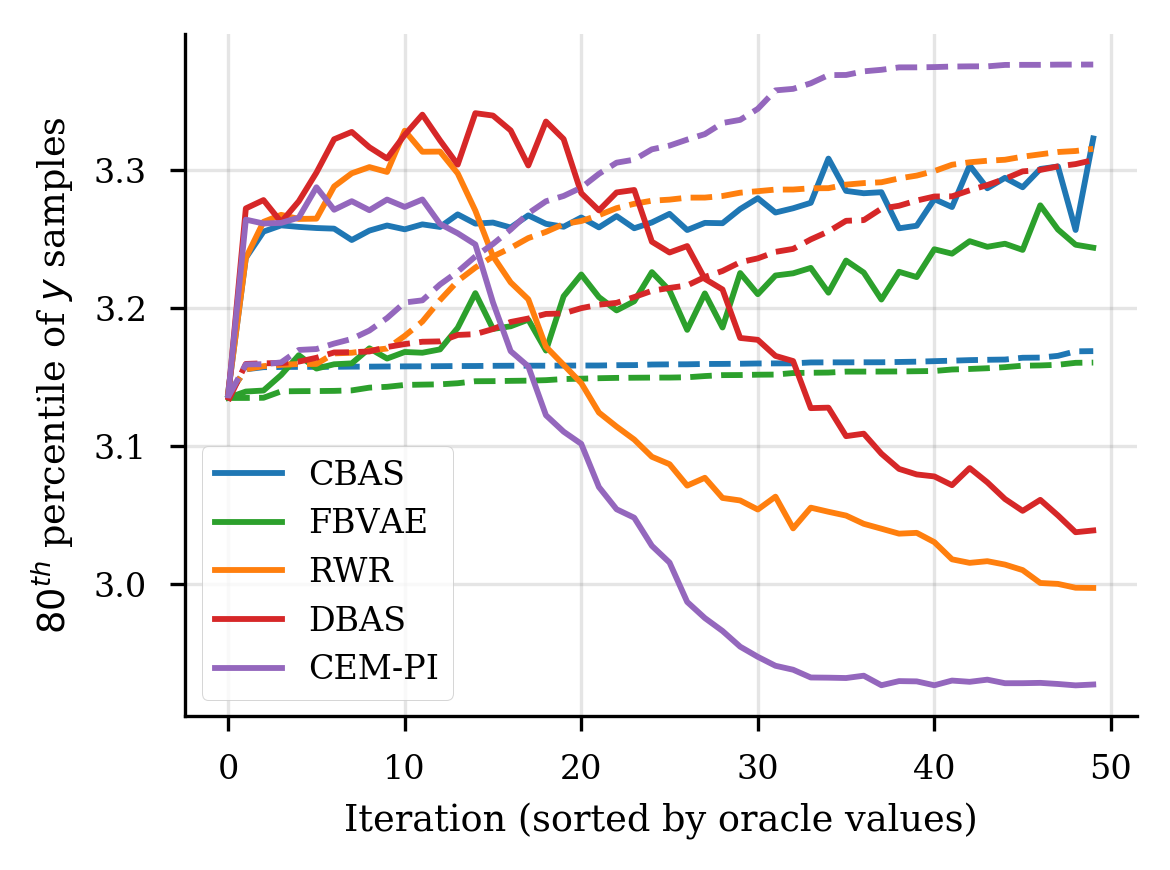

plots/traj_0.8_2_2_all.png


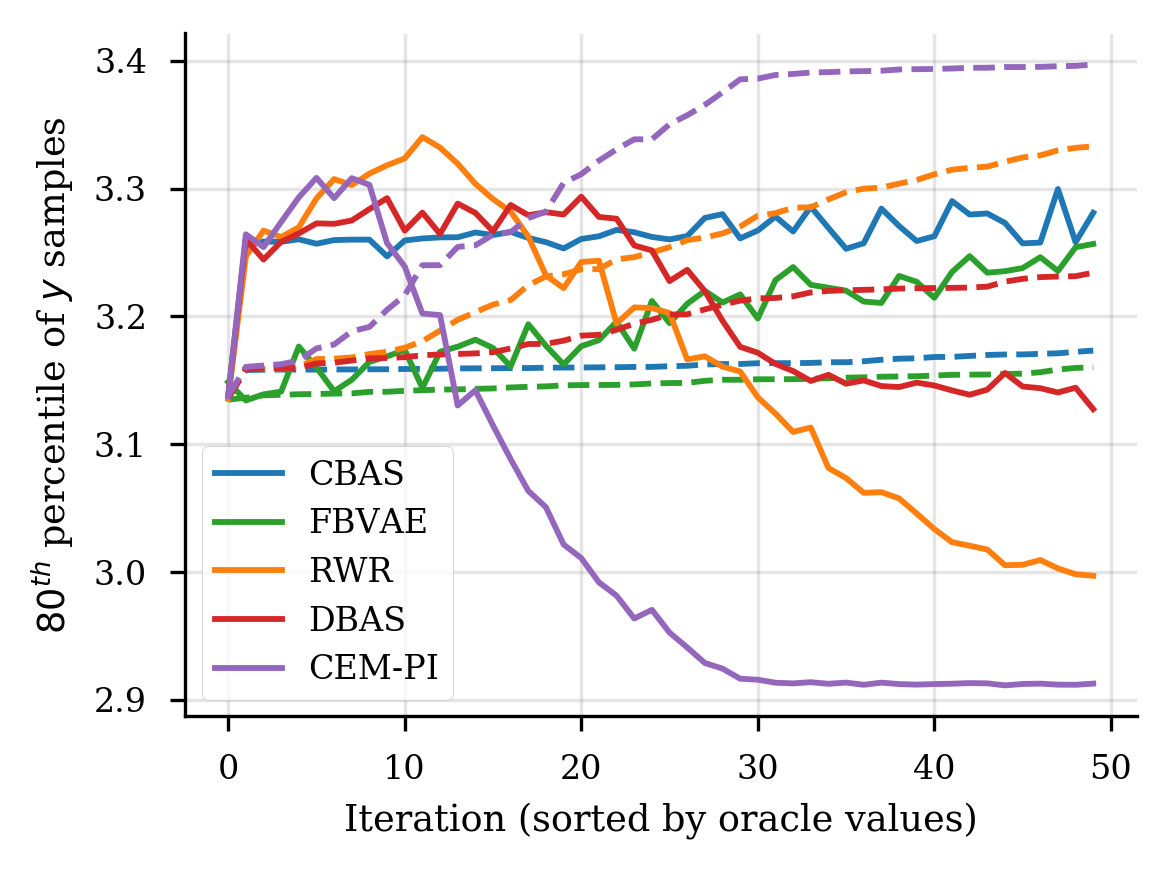

plots/traj_0.8_3_0_all.png


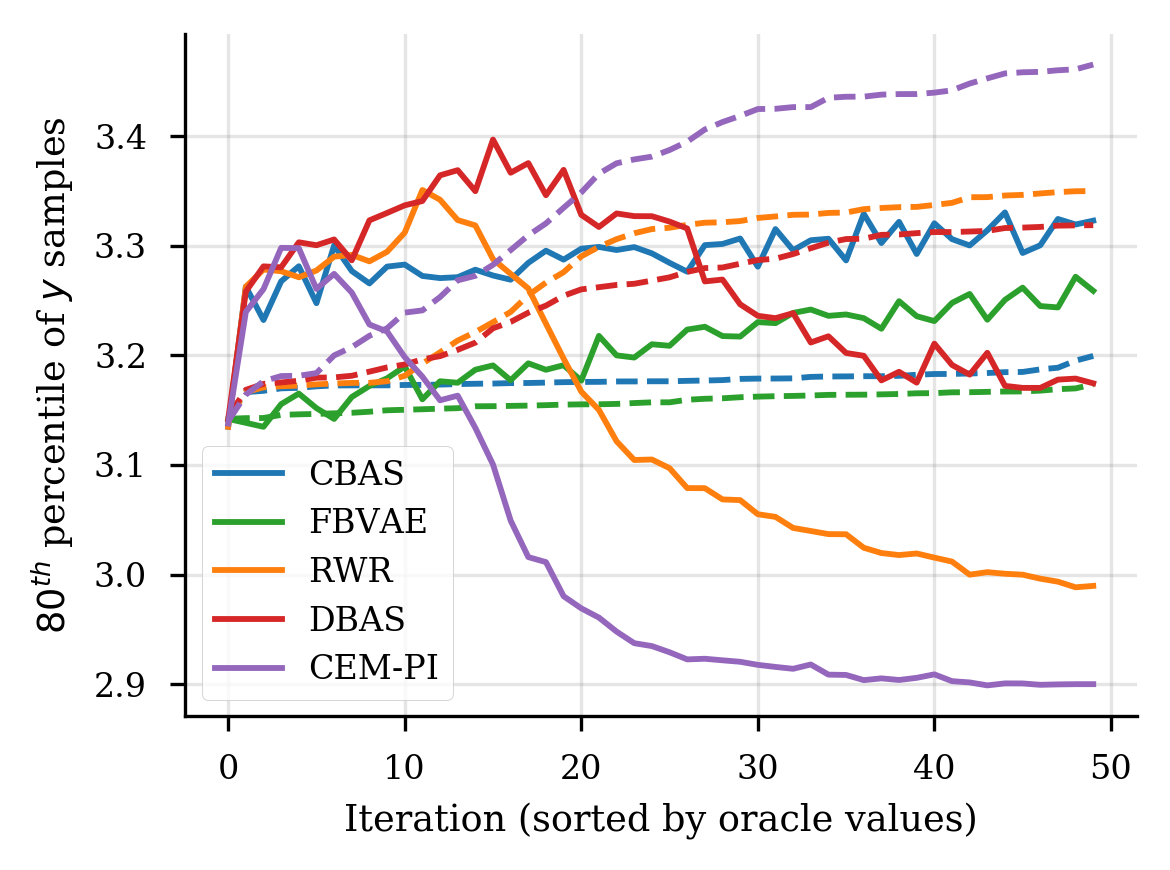

plots/traj_0.8_3_1_all.png


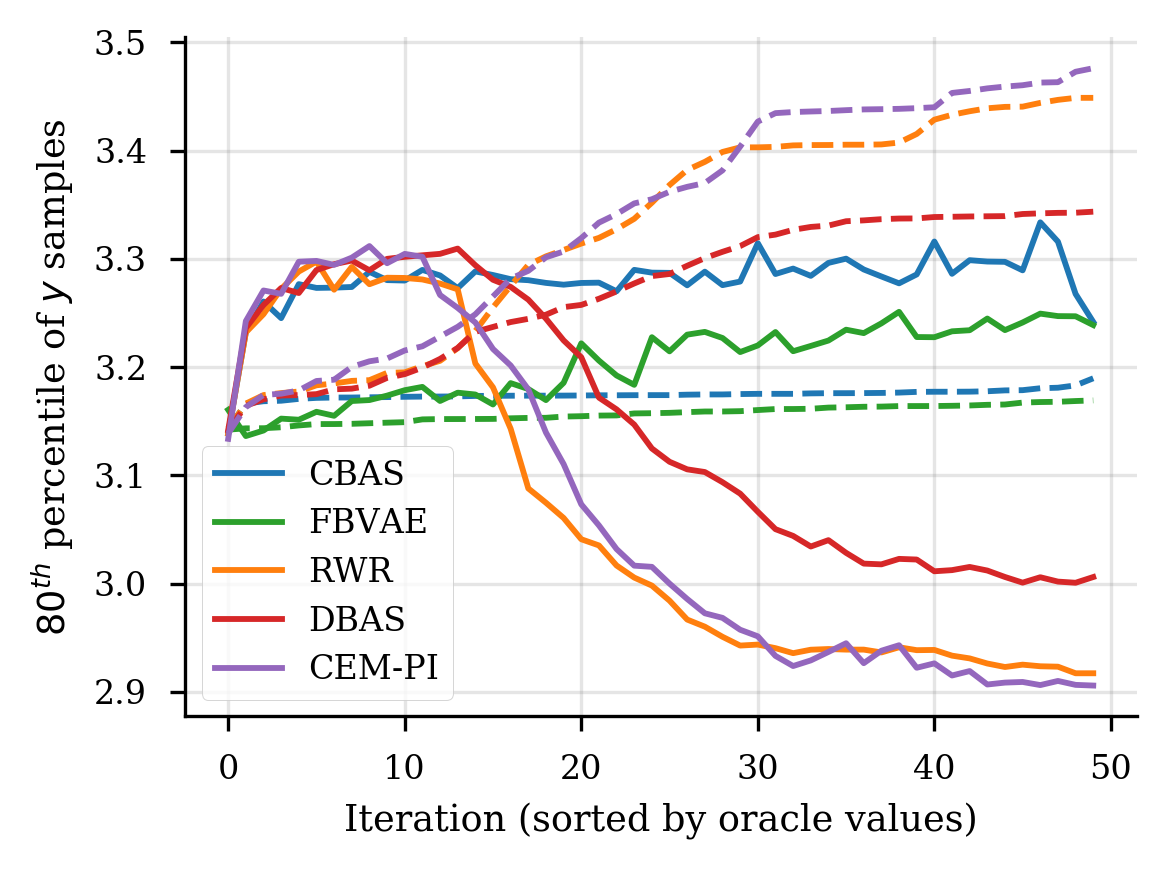

plots/traj_0.8_3_2_all.png


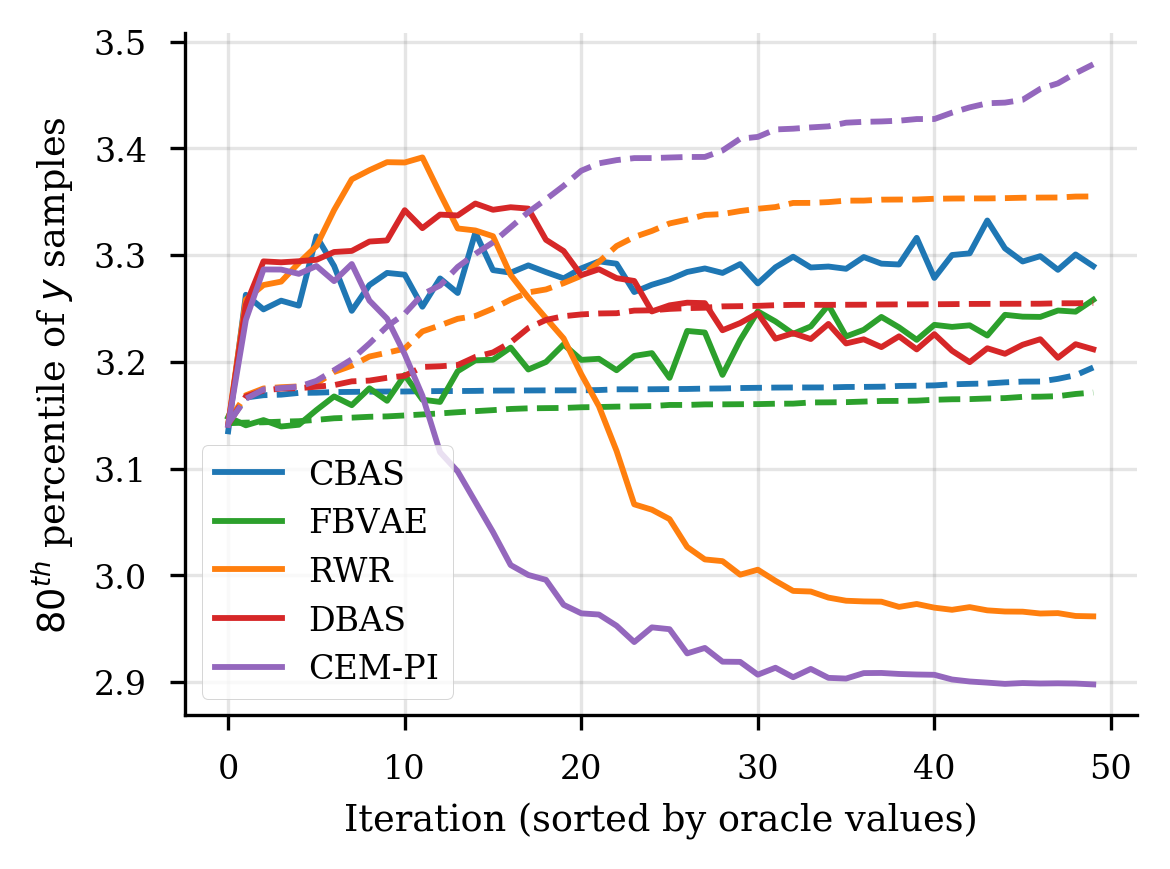

In [58]:
plot_traj(quantile=0.80, sort=True, mean=False, use_first=50, sub=False)

In [11]:
def plot_comparison(quantiles, mean=False, use_first=50):
    repeats = 3
    fig = plt.figure(figsize=(4, 3))
    width = 0.25
    ml_methods = ['cbas', 'fbvae', 'dbas', 'rwr', 'cem-pi']
    all_methods = deepcopy(ml_methods)
    include_killoran_bomb = True
    total = len(ml_methods)
#     quantiles = [0.5, 0.8, 0.95, 1]
    if include_killoran_bomb:
        total += 3
        all_methods += ['bombarelli', 'bombarelli-unconstrained', 'killoran']
    shades = [0.4, 0.6, 0.8, 1]
    for i in range(1, 4):  # Loop over random state
        prev_results = None
        for l in range(len(quantiles)):
            quantile = quantiles[l]
            results = np.zeros((total, repeats))
            for k in range(repeats):
                suffix = '_5k_%i_%i' % (i, k)
                for j in range(len(ml_methods)):
                    method = ml_methods[j]
                    oracle_samples = np.load("results/%s_oracle_samples%s.npy" %(method, suffix))[:use_first]
                    gt_samples = np.load("results/%s_gt_samples%s.npy" %(method, suffix))[:use_first]
                    
                    oracle_samples = oracle_samples.flatten()
                    gt_samples = gt_samples.flatten()
                    
#                     if mean:
#                         oracle_vals= np.mean(oracle_samples, axis=1)
#                         gt_vals = np.mean(gt_samples, axis=1)
#                     else:
#                         oracle_vals= np.percentile(oracle_samples, quantile*100, axis=1)
#                         gt_vals = np.percentile(gt_samples, quantile*100, axis=1)
                    top_oracle_idxs = np.where(oracle_samples >= np.percentile(oracle_samples, quantile*100))
                    gt_at_top_oracle = gt_samples[top_oracle_idxs]
                    results[j, k] = np.mean(gt_at_top_oracle)
#                     oracle_argmax = np.argmax(oracle_vals)
#                     gt_at_oracle_max = gt_vals[oracle_argmax]
#                     results[j, k] = gt_at_oracle_max

            if include_killoran_bomb:
                killoran_results = np.load("results/killoran_results_5k_%i.npy" % i)
                bombarelli_results = np.load("results/bombarelli_results_5k_%i.npy" % i)
                bombarelli_results2 = np.load("results/bombarelli_results_unconstrained_5k_%i.npy" % i)
                results[len(ml_methods), :] = bombarelli_results[1]
                results[len(ml_methods)+1, :] = bombarelli_results2[1]
                results[len(ml_methods)+2, :] = killoran_results[1]

            xs = range(total)
            xs = [xi + i*width for xi in xs]

            for j in range(total):
                method = all_methods[j]
                c = METHOD_COLORS[method]
                val = results[j].mean(axis=-1)
                if i == 1 and j == 0:
                    lbl = "$%i^{th}$ Percentile" % int(100*quantile)
                else:
                    lbl=None
                if quantile == quantiles[0]:
                    plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=0.5, label=lbl, zorder=l+1)
                else:
                    prev_val = prev_results[j].mean(axis=-1)
                    plt.bar(xs[j],val-prev_val, width=width, 
                            bottom = prev_val,
                            color=lighten_color(c, shades[l]), edgecolor='k', 
                            linewidth=0.5, label=lbl, zorder=l+1)
#             plt.errorbar(xs[j], results[j].mean(axis=-1), c='k', 
#                          yerr=results[j].std(axis=-1), capsize=2, 
#                          elinewidth=1, markeredgewidth=1)
            prev_results = results
        
    plt.xticks([i + 2*width for i in range(total)])
    all_lbls = [ml_methods[j].upper() for j in range(len(ml_methods))]
    for i in range(len(all_lbls)):
        if all_lbls[i] == 'CBAS':
            all_lbls[i] = 'CbAS'
        elif all_lbls[i] == 'DBAS':
            all_lbls[i] = 'DbAS'
            
    if include_killoran_bomb:
        all_lbls += ['GB', 'GB-NO', 'AM-VAE']
    plt.gca().set_xticklabels(all_lbls, rotation=60)
    y_label = "Ground Truth Values"
#     if mean:
#         y_label += " (mean)"
#     else:
#         y_label += " ($%i^{th}$ percentile)" % int(quantile*100)
    plt.ylabel(y_label)
    plt.ylim([2.85, 3.4])
    plt.grid(True)
    plt.legend(fontsize=5, frameon=True, loc='upper right')
    plt.gca().set_axisbelow(True)
    plt.gca().grid(color='gray', alpha=0.2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    plt.savefig("plots/compare_results.png", dpi=500)
    plt.show()
            

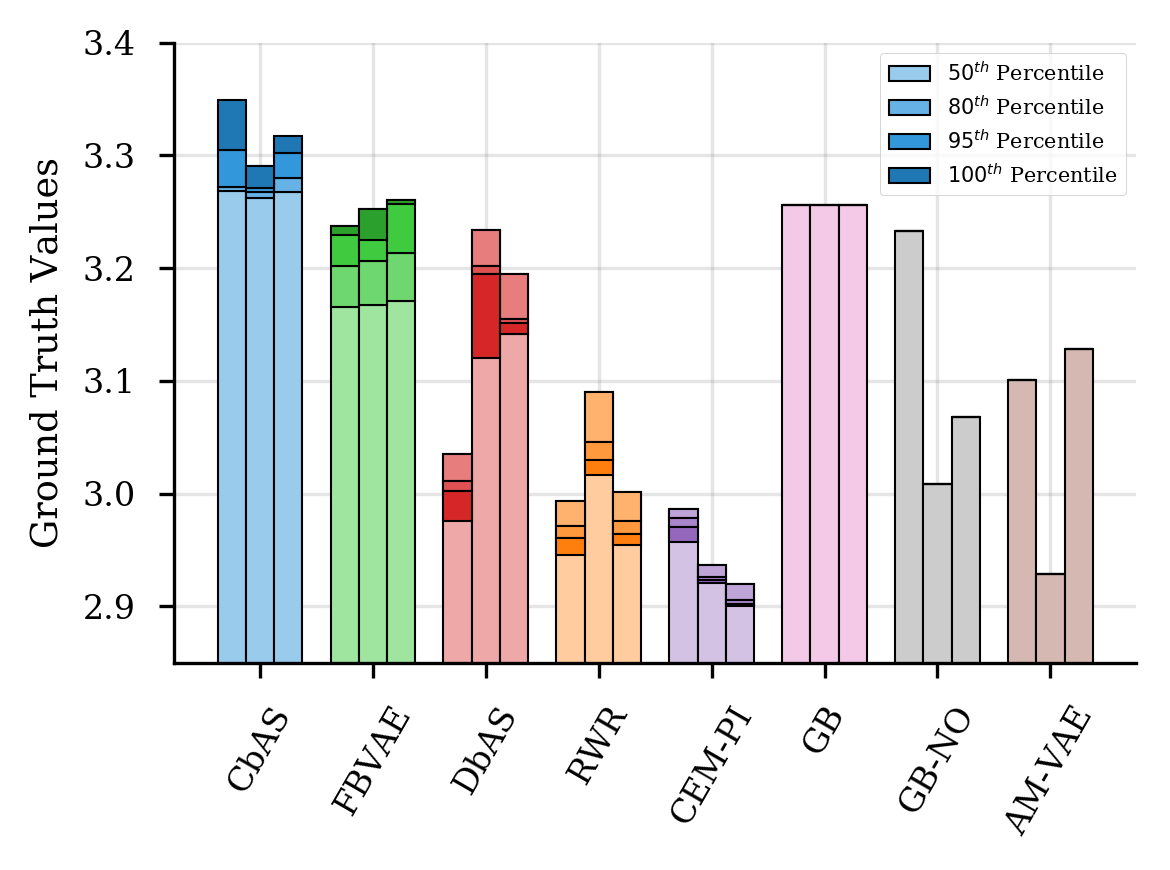

In [12]:
plot_comparison(quantiles=[0.5, 0.8, 0.95, 1], mean=False, use_first=50)

In [ ]:
def gather_sequences():
    methods = [ 'cbas', 'fbvae', 'rwr', 'dbas', 'cem-pi']
    seqs = {'method':[], 'seq':[]}
    for method in methods:
        for i in range(1, 4):
            for j in range(3):
                suffix = '_5k_%i_%i' %(i, j)
                f = 'results/%s_max%s.json' % (method, suffix)
                seqs['method'].append(method)
                with open(f) as outfile:
                    data = json.load(outfile)
                    seqs['seq'].append(data['oracle_max_seq'])
                    
    methods=['bombarelli','bombarelli_unconstrained', 'killoran']    
    for method in methods:
        for i in range(1, 4):
            suffix = '_5k_%i' % i
            seqs['method'].append(method)
            if method == 'bombarelli_unconstrained':
                suffix = '_unconstrained' + suffix
                f = 'results/%s_max%s.json' % ('bombarelli', suffix)
            else:
                f = 'results/%s_max%s.json' % (method, suffix)
    #         seqs['method'].append(method)
            with open(f) as outfile:
                data = json.load(outfile)
                seqs['seq'].append(data['oracle_max_seq'][0])
    
    df = pd.DataFrame(seqs)
    return df
                

In [ ]:
all_seqs = gather_sequences()
print(all_seqs)
all_seqs.to_csv("results/max_seqs.csv")